In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.utils.data as data_util
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
#from torchinfo import summary
from torchsummary import summary

In [2]:
CUDA = torch.cuda.is_available()
print(CUDA)

device = torch.device('cuda:0' if CUDA else 'cpu')

True


In [3]:
elec = pd.read_csv('elec_merge.csv')
nelec = pd.read_csv('n_elec_merge.csv')

In [4]:
scaler_nelec = MinMaxScaler()
scaler_elec = MinMaxScaler()

scaler_nelec.fit(nelec)
scaler_elec.fit(elec)

scaled_nelec = scaler_nelec.transform(nelec)
scaled_elec = scaler_elec.transform(elec)

new_nelec = pd.DataFrame(scaled_nelec, index=nelec.index, columns=nelec.columns)
new_elec = pd.DataFrame(scaled_elec, index=elec.index, columns=elec.columns)

In [5]:
input_nelec = new_nelec.iloc[:-1,].reset_index(drop=True)
output_nelec = new_nelec[['n_elec']].iloc[1:].reset_index(drop=True)
output_nelec.columns = ['nelec']

input_elec = new_elec.iloc[:-1,].reset_index(drop=True)
output_elec = new_elec[['ELEC']].iloc[1:].reset_index(drop=True)
output_elec.columns = ['elec']

nelec = pd.concat([input_nelec, output_nelec], axis=1)
elec = pd.concat([input_elec, output_elec], axis=1)

In [6]:
# data = pd.read_csv('dann_nelec_elec.csv')
# data = pd.read_csv('dann_nelec_elec_weired.csv')
# DATA = data.iloc[:-1,].reset_index(drop=True)
# NELEC = data[['N_ELEC']].iloc[1:].reset_index(drop=True)
# NELEC.columns = ['nelec']
# ELEC = data[['ELEC']].iloc[1:].reset_index(drop=True)
# ELEC.columns = ['elec']

In [7]:
# scaler = MinMaxScaler()
# scaler.fit(DATA)

# scaled = scaler.transform(DATA)
# new = pd.DataFrame(scaled, index=DATA.index, columns=DATA.columns)

# nelec = pd.concat([new, NELEC], axis=1)
# elec = pd.concat([new, ELEC], axis=1)

In [8]:
standard_nelec = int(len(nelec) * 0.7)
standard_elec = int(len(elec) * 0.7)

nelec_train = nelec.iloc[:standard_nelec]
nelec_test = nelec.iloc[standard_nelec:].reset_index(drop=True)

elec_train = elec.iloc[:standard_elec]
elec_test = elec.iloc[standard_elec:].reset_index(drop=True)

In [9]:
nelec_trainx = nelec_train.drop(['nelec'], axis=1)
nelec_trainy = nelec_train[['nelec']]

nelec_testx = nelec_test.drop(['nelec'], axis=1)
nelec_testy = nelec_test[['nelec']]

elec_trainx = elec_train.drop(['elec'], axis=1)
elec_trainy = elec_train[['elec']]

elec_testx = elec_test.drop(['elec'], axis=1)
elec_testy = elec_test[['elec']]

In [10]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

nelec_trainx, nelec_trainy = buildDataSet(nelec_trainx, nelec_trainy, 3)
nelec_testx, nelec_testy = buildDataSet(nelec_testx, nelec_testy, 3)

elec_trainx, elec_trainy = buildDataSet(elec_trainx, elec_trainy, 3)
elec_testx, elec_testy = buildDataSet(elec_testx, elec_testy, 3)

In [11]:
print(nelec_trainx.shape)
print(nelec_trainy.shape)
print(nelec_testx.shape)
print(nelec_testy.shape)
print(elec_trainx.shape)
print(elec_trainy.shape)
print(elec_testx.shape)
print(elec_testy.shape)

(20413, 3, 13)
(20413, 1)
(8748, 3, 13)
(8748, 1)
(2988, 3, 13)
(2988, 1)
(1279, 3, 13)
(1279, 1)


In [12]:
# 텐서로 변환
nelec_trainx_tensor = torch.FloatTensor(nelec_trainx)
nelec_trainy_tensor = torch.FloatTensor(nelec_trainy)

nelec_testx_tensor = torch.FloatTensor(nelec_testx)
nelec_testy_tensor = torch.FloatTensor(nelec_testy)

elec_trainx_tensor = torch.FloatTensor(elec_trainx)
elec_trainy_tensor = torch.FloatTensor(elec_trainy)

elec_testx_tensor = torch.FloatTensor(elec_testx)
elec_testy_tensor = torch.FloatTensor(elec_testy)

In [13]:
# 텐서 형태로 데이터 정의
nelec_train = TensorDataset(nelec_trainx_tensor, nelec_trainy_tensor)
nelec_test = TensorDataset(nelec_testx_tensor, nelec_testy_tensor)
elec_train = TensorDataset(elec_trainx_tensor, elec_trainy_tensor)
elec_test = TensorDataset(elec_testx_tensor, elec_testy_tensor)

In [14]:
batch = 64
source_train = DataLoader(nelec_train,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

source_test = DataLoader(nelec_test,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

target_train = DataLoader(elec_train,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

target_test = DataLoader(elec_test,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

# 모델 구조 선언

In [15]:
import torch.nn as nn
import torch.nn.functional as F

### GradientReversalLayer

In [16]:
# class GradientReversalLayer(torch.autograd.Function):
#     def forward(self, x):
#         return x.view_as(x)

#     def backward(self, grad_output):
#         return (grad_output * -1)

class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return (grad_output * -1), None

class GradientReversalLayer(torch.nn.Module):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def forward(self, x):
        return GradientReversalFunction.apply(x)

### LSTM for Feature Extraction

In [17]:
class lstm(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(lstm, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=False)
        self.dropout = nn.Dropout(0.5)
        self.gelu = nn.GELU()
        
    def reset_hidden_state(self):
        self.hidden(
            torch.zeros(self.layers, self.seq_len, self.hidden_dim), # hidden state
            torch.zeros(self.layers, self.seq_len, self.hidden_dim) # cell state
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.gelu(x)
        x = self.fc(x[:, -1, :]) #LSTM 레이어의 마지막 타임 스텝에 해당하는 은닉 상태
        x = self.dropout(x)
        x = x.view(-1, 64)
        return x

In [18]:
class domain_regression(nn.Module):
    def __init__(self):
        super(domain_regression, self).__init__()
        self.regression_layer1 = nn.Linear(64, 100)
        self.regression_layer2 = nn.Linear(100, 100)
        self.regression_layer3 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = F.relu(self.regression_layer1(x))
        x = F.relu(self.regression_layer2(x))
        x = self.regression_layer3(x)
        return x

### Domain Classification

In [19]:
class domain_classfication(nn.Module):
    def __init__(self):
        super(domain_classfication, self).__init__()
        self.classification_layer0 = GradientReversalLayer()
        self.classification_layer1 = nn.Linear(64, 64)
        self.classification_layer2 = nn.Linear(64, 32)
        self.classification_layer3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.classification_layer0(x)
        x = F.relu(self.classification_layer1(x))
        x = F.relu(self.classification_layer2(x))
        x = torch.sigmoid(self.classification_layer3(x))
        return x 

### Set the DANN

In [20]:
class dann(nn.Module):
    def __init__(self, lstm):
        super(dann, self).__init__()
        self.lstm = lstm
        self.regression = domain_regression()
        self.classification = domain_classfication()
        
    def forward(self, x):
        feature = self.lstm(x)
        reg_output = self.regression(feature)
        cla_output = self.classification(feature)
        
        return reg_output, cla_output

### Loss 선언

In [21]:
class dann_loss(nn.Module):
    def __init__(self):
        super(dann_loss, self).__init__()
        self.reg = nn.L1Loss() # 회귀 L1 손실 == MAE
        self.cla = nn.BCEWithLogitsLoss() # 도메인 분류
        
    def forward(self, result, reg_real, domain_num, alpha=1):
        reg_output, cla_output = result
        batch_size = reg_output.shape[0]
        cla_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)
        
        reg_loss = self.reg(reg_output, reg_real)
        cla_loss = self.cla(cla_output, cla_target)
        loss = reg_loss + cla_loss * alpha
        return loss

# 훈련

In [22]:
from torch.optim.lr_scheduler import LinearLR

batch = 64
seq_len = 3
data_dim = 13
hidden_dim = 64
output_dim = 64
layers = 2 
alpha = 1.0

my_lstm = lstm(data_dim, hidden_dim, seq_len, output_dim, layers).to(device)
model = dann(my_lstm).to(device)
loss_fn = dann_loss().to(device)

epochs = 10

model.train() # 훈련 모드 설정

optimizer= torch.optim.Adamax(model.parameters(), lr = 0.01)
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters = epochs * len(source_train))

for i in range(1, epochs + 1):
    total_loss = 0
    source_total_loss = 0
    target_total_loss = 0
    #for step in tqdm(range(len(source_train))):
    for step, (source_data, target_data) in enumerate(zip(source_train, target_train)):
        #source_data = next(iter(source_train))
        #target_data = next(iter(target_train))
        
        source_x = source_data[0].to(device)
        source_y = source_data[1].to(device)
        target_x = target_data[0].to(device)
        target_y = target_data[1].to(device)
        
        # 순전파
        source_result = model(source_x)
        target_result = model(target_x)
        
        # 순전파 loss
        source_loss = loss_fn(source_result, source_y, 0, alpha=alpha) # 소스 도메인 레이블 0
        target_loss = loss_fn(target_result, target_y, 1, alpha=alpha) # 타겟 도메인 레이블 1
        loss = source_loss + target_loss
        
        source_total_loss += source_loss.item()
        target_total_loss += target_loss.item()
        total_loss += loss.item()
        
        # 그래디언트 계산 및 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    print('Epoch : %d, Total Avg Loss : %.4f' % (i, total_loss / len(source_train)))     
    print('Source Avg Loss : %.4f' % (source_total_loss / len(source_train)))
    print('Target Avg Loss : %.4f' % (target_total_loss / len(source_train)))
    print('')

Epoch : 1, Total Avg Loss : 0.2556
Source Avg Loss : 0.1434
Target Avg Loss : 0.1122

Epoch : 2, Total Avg Loss : 0.2419
Source Avg Loss : 0.1307
Target Avg Loss : 0.1111

Epoch : 3, Total Avg Loss : 0.2519
Source Avg Loss : 0.1361
Target Avg Loss : 0.1158

Epoch : 4, Total Avg Loss : 0.2331
Source Avg Loss : 0.1236
Target Avg Loss : 0.1095

Epoch : 5, Total Avg Loss : 0.2817
Source Avg Loss : 0.1960
Target Avg Loss : 0.0858

Epoch : 6, Total Avg Loss : 0.2808
Source Avg Loss : 0.2045
Target Avg Loss : 0.0763

Epoch : 7, Total Avg Loss : 0.2792
Source Avg Loss : 0.2017
Target Avg Loss : 0.0775

Epoch : 8, Total Avg Loss : 0.2654
Source Avg Loss : 0.2039
Target Avg Loss : 0.0615

Epoch : 9, Total Avg Loss : 0.2627
Source Avg Loss : 0.2016
Target Avg Loss : 0.0612

Epoch : 10, Total Avg Loss : 0.2630
Source Avg Loss : 0.2009
Target Avg Loss : 0.0622



In [24]:
from torchinfo import summary

summary(model, (64,3,13))

Layer (type:depth-idx)                   Output Shape              Param #
dann                                     [64, 1]                   --
├─lstm: 1-1                              [64, 64]                  --
│    └─LSTM: 2-1                         [64, 3, 64]               53,504
│    └─GELU: 2-2                         [64, 3, 64]               --
│    └─Linear: 2-3                       [64, 64]                  4,096
│    └─Dropout: 2-4                      [64, 64]                  --
├─domain_regression: 1-2                 [64, 1]                   --
│    └─Linear: 2-5                       [64, 100]                 6,500
│    └─Linear: 2-6                       [64, 100]                 10,100
│    └─Linear: 2-7                       [64, 1]                   101
├─domain_classfication: 1-3              [64, 1]                   --
│    └─GradientReversalLayer: 2-8        [64, 64]                  --
│    └─Linear: 2-9                       [64, 64]                  4,1

# 테스트

In [23]:
from sklearn.metrics import r2_score

model.eval()  # 테스트 모드로 전환

s_pred = []  # MNIST 데이터셋의 예측값을 저장할 리스트
t_pred = []  # SVHN 데이터셋의 예측값을 저장할 리스트
s_real = []
t_real = []

#for step in tqdm(range(len(source_train))):
for step, (source_data, target_data) in enumerate(zip(source_train, target_train)):
    # source_data = next(iter(source_train))
    # target_data = next(iter(target_train))

    sourcex = source_data[0].to(device)
    sourcey = source_data[1].to(device)
    targetx = target_data[0].to(device)
    targety = target_data[1].to(device)
    # domain 분류와 관련된 logits은 사용하지 않기에 _로 받아서 처리
    _, source_pred = model(sourcex)
    _, target_pred = model(targetx)

    ## 예측값을 리스트에 저장
    s_pred.extend(source_pred.detach().cpu().numpy())
    t_pred.extend(target_pred.detach().cpu().numpy())
    s_real.extend(sourcey.detach().cpu().numpy())
    t_real.extend(targety.detach().cpu().numpy())

# R2 스코어 계산
s_r2 = r2_score(s_real, s_pred)
t_r2 = r2_score(t_real, t_pred)

print('SOURCE R2 Score:', s_r2)
print('TARGET R2 Score:', t_r2)

SOURCE R2 Score: -10.65100702275795
TARGET R2 Score: -2.709799085226641


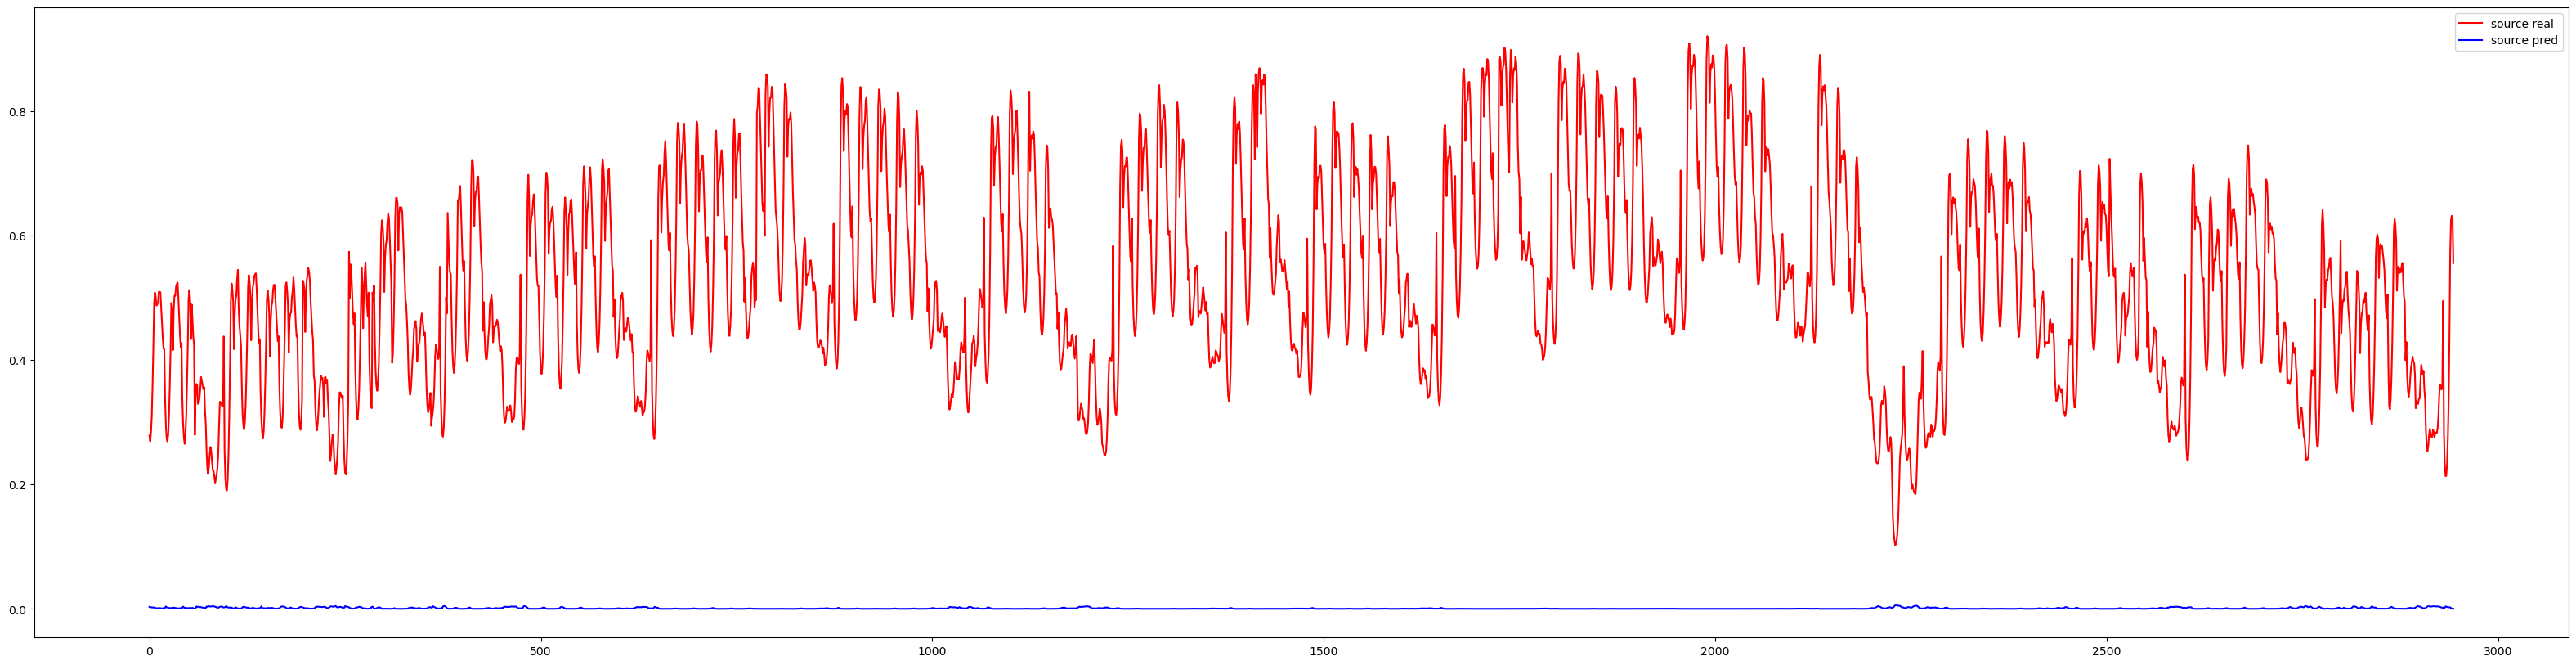

In [24]:
plt.figure(figsize=(40,10))
plt.plot(s_real, color='red', label='source real')
plt.plot(s_pred, color='blue', label='source pred')
plt.legend()
plt.show()

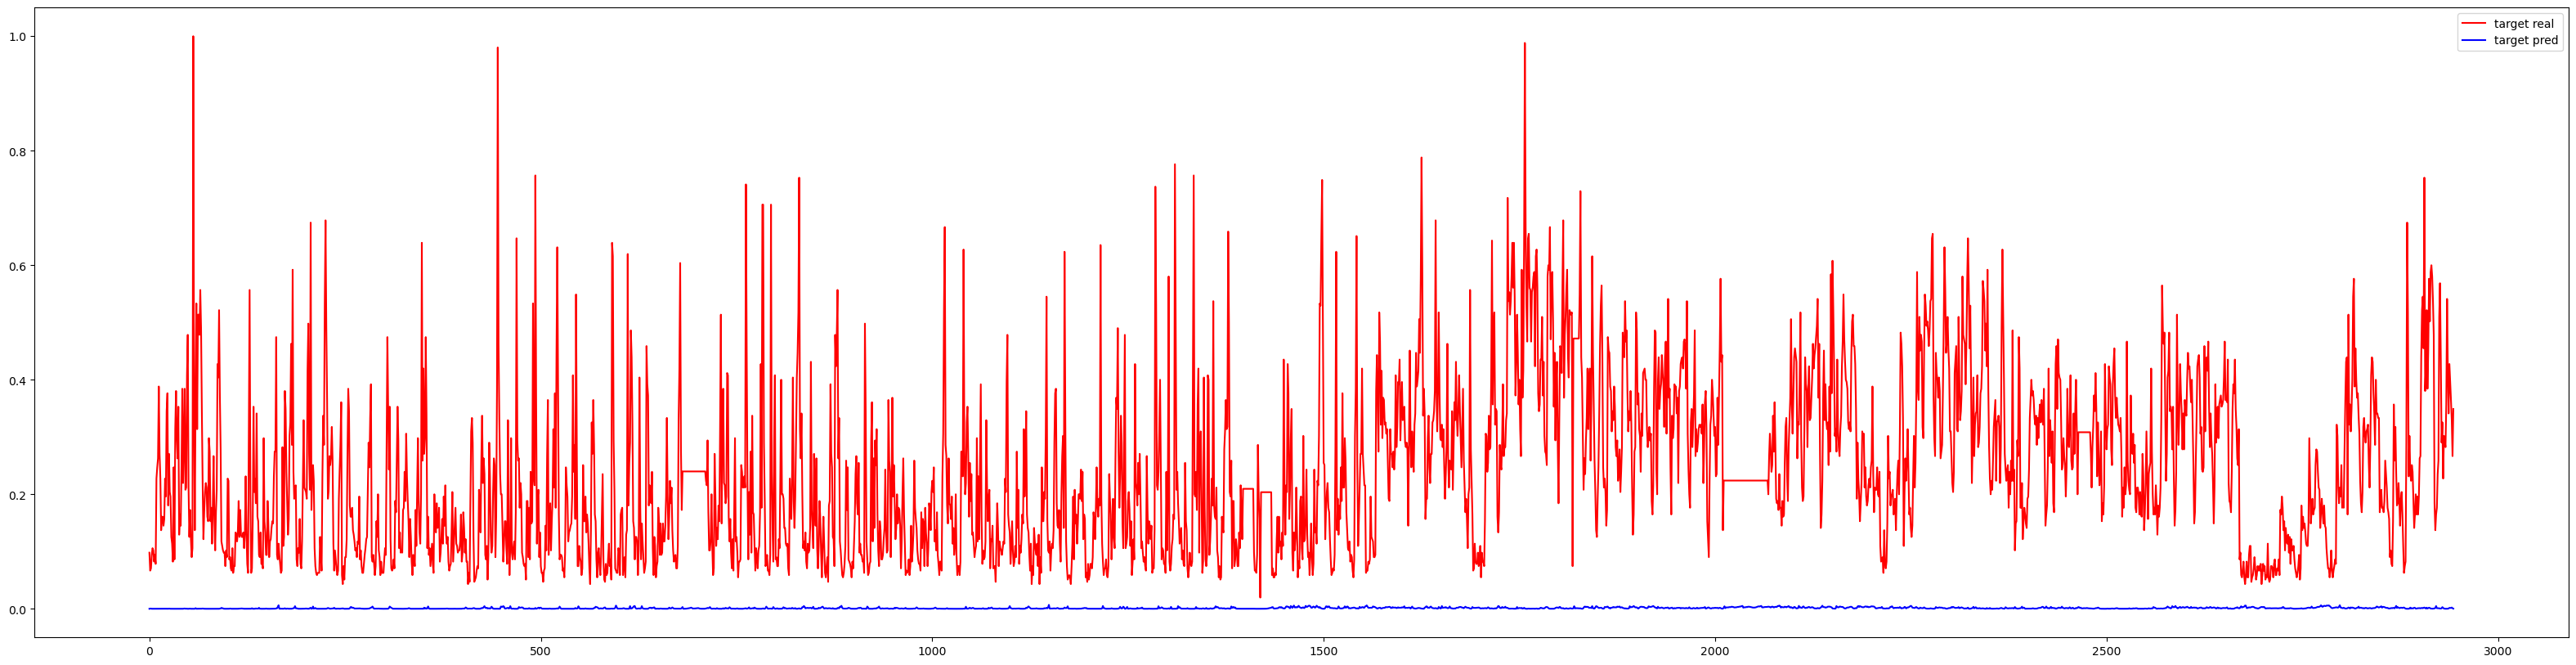

In [25]:
plt.figure(figsize=(40,10))
plt.plot(t_real, color='red', label='target real')
plt.plot(t_pred, color='blue', label='target pred')
plt.legend()
plt.show()

### Domain Embedding Space 시각화

In [26]:
# 가장 앞 batch의 250개씩의 데이터만 샘플링
source_tsne = DataLoader(nelec_train,
                        batch_size=1000,
                        shuffle=False,  
                        drop_last=True)

target_tsne = DataLoader(elec_train,
                        batch_size=1000,
                        shuffle=False,  
                        drop_last=True)

source_tsne2 = next(iter(source_tsne))
target_tsne2 = next(iter(target_tsne))

source_x_TNSE = source_tsne2[0].to(device)
source_y_TNSE = source_tsne2[1].to(device)

target_x_TNSE = target_tsne2[0].to(device)
target_y_TNSE = target_tsne2[1].to(device)

# 학습된 모델의 LSTM 부분만 활용 (100차원 임베딩 벡터를 받아오는 과정)
source_vector = model.lstm(source_x_TNSE)
target_vector = model.lstm(target_x_TNSE)

In [27]:
from sklearn.manifold import TSNE

df = pd.DataFrame(np.concatenate([source_vector.cpu().detach().numpy(), target_vector.cpu().detach().numpy()]))

tsne_np = TSNE(n_components=2).fit_transform(df)
tsne_df = pd.DataFrame(tsne_np, columns=['component 0', 'component 1'])

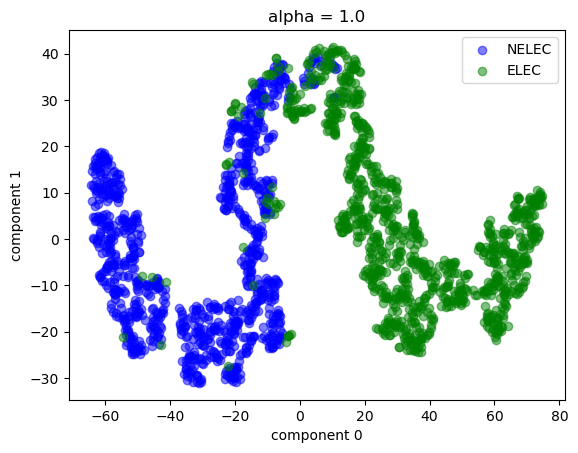

In [28]:
tsne_df_0 = tsne_df.loc[:1000]
tsne_df_1 = tsne_df.loc[1000:]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color='blue', label='NELEC', alpha=0.5)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color='green', label='ELEC', alpha=0.5)

plt.title('alpha = '+ str(alpha))
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()